In [1]:
# environment py39, python = 3.9
import tarfile
import warnings
from glob import glob

import anndata
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import scirpy as ir
import numpy as np

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/umap/distances.

Load transcriptomics and TCR files out of cell ranger into adata format for analysis

files including:
- library 1: lymph node (WT, RII, PD1, 2KO, 3KO)
- library 2: liver ((WT, RII, PD1, 2KO, 3KO))

(each genotype can be differentiated by a hashtag, already demultiplex in the cell ranger pipeline)

### Testing loading one sample

In [2]:
# Load the TCR data
adata_tcr_LV2KO = ir.io.read_10x_vdj(
    "data/LV_2KO_filtered_contig_annotations.csv"
)

# Load the associated transcriptomics data
adata_LV2KO = sc.read_10x_h5(
    "data/LV_2KO_sample_filtered_feature_bc_matrix.h5"
)
adata_LV2KO.var_names_make_unique()

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/aligned_mapping.py:54: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [14]:
adata_tcr_LV2KO

AnnData object with n_obs × n_vars = 8362 × 0
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing'
    uns: 'scirpy_version', 'chain_indices'
    obsm: 'airr', 'chain_indices'

In [4]:
adata_LV2KO.shape

(12711, 32285)

In [5]:
mdata_LV2KO = mu.MuData({"gex": adata_LV2KO, "airr": adata_tcr_LV2KO})

In [10]:
mdata_LV2KO

MuData object with n_obs × n_vars = 12711 × 32285
  2 modalities
    gex:	12711 x 32285
      var:	'gene_ids', 'feature_types', 'genome'
      uns:	'log1p', 'pca', 'neighbors', 'umap', 'airr:receptor_type_colors'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      obsp:	'distances', 'connectivities'
    airr:	8362 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing'
      uns:	'scirpy_version', 'chain_indices'
      obsm:	'airr', 'chain_indices'

In [6]:
sc.pp.log1p(mdata_LV2KO["gex"])
sc.pp.pca(mdata_LV2KO["gex"], svd_solver="arpack")
sc.pp.neighbors(mdata_LV2KO["gex"])
sc.tl.umap(mdata_LV2KO["gex"])

In [7]:
ir.pp.index_chains(mdata_LV2KO)
ir.tl.chain_qc(mdata_LV2KO)

100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


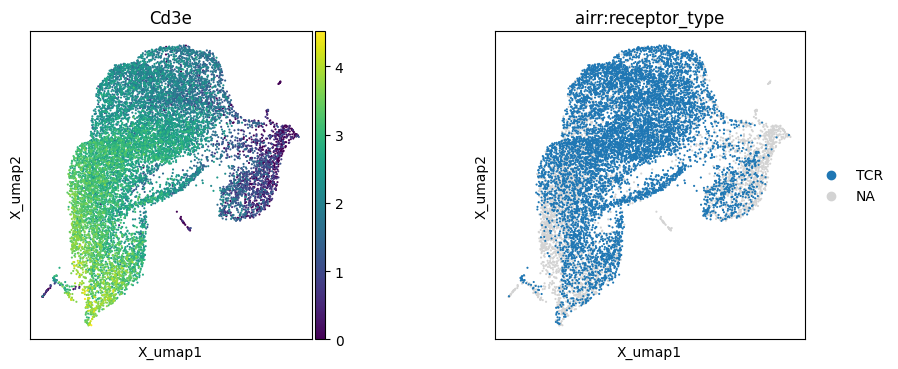

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"wspace": 0.5})
mu.pl.embedding(mdata_LV2KO, basis="gex:umap", color=["Cd3e"], ax=ax0, show=False)
mu.pl.embedding(mdata_LV2KO, basis="gex:umap", color=["airr:receptor_type"], ax=ax1)


In [11]:
sc.pp.filter_genes(mdata_LV2KO["gex"], min_cells=10)
sc.pp.filter_cells(mdata_LV2KO["gex"], min_genes=100)

In [13]:

sc.pp.highly_variable_genes(mdata_LV2KO["gex"], flavor="cell_ranger", n_top_genes=5000)
sc.tl.pca(mdata_LV2KO["gex"])
sc.pp.neighbors(mdata_LV2KO["gex"])

### Load all samples

In [2]:
samples = ['LN_WT', 'LN_RII', 'LN_PD1', 'LN_2KO', 'LN_3KO',
           'LV_WT', 'LV_RII1','LV_RII2', 'LV_PD1', 'LV_2KO', 'LV_3KO']

In [16]:
s = 'LA_WT'
fvdj = 'data/'+ s + '_filtered_contig_annotations.csv'
fvdj

'data/LA_WT_filtered_contig_annotations.csv'

In [3]:
adata_gex = [] #transcriptomics data
adata_tcrs = [] #TCRs
for sample in samples:
    fvdj = 'data/'+ sample + '_filtered_contig_annotations.csv'
    fgexfbc = 'data/'+ sample + '_sample_filtered_feature_bc_matrix.h5'

    adata_tcr = ir.io.read_10x_vdj(fvdj)
    adata = sc.read_10x_h5(fgexfbc, gex_only=False) #gex_only set to False to include hash tag info
    
    #ir.pp.merge_with_ir(adata, adata_tcr)
    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    adata.obs["hash"] = sample

    adata_gex.append(adata)
    adata_tcrs.append(adata_tcr)
    
# Merge anndata objects
#adata = anndata.concat(adatas)

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/aligned_mapping.py:54: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/si

In [22]:
adata_gex[0].obs

,hash
AAACCTGAGTGTGAAT-1,LN_WT
AAACCTGCAAATTGCC-1,LN_WT
AAACCTGGTACATGTC-1,LN_WT
AAACCTGGTACGCTGC-1,LN_WT
AAACCTGTCCAAGTAC-1,LN_WT
...,...
TTTGGTTTCTTGCAAG-1,LN_WT
TTTGTCACACCACGTG-1,LN_WT
TTTGTCACACCCATGG-1,LN_WT
TTTGTCACATTGGTAC-1,LN_WT


#### transcriptomics

In [4]:
gex_all = anndata.concat(adata_gex, join='outer', fill_value=0)

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
gex_all

AnnData object with n_obs × n_vars = 46095 × 32285
    obs: 'hash'

In [6]:
gex_all.obs

,hash
AAACCTGAGTGTGAAT-1,LN_WT
AAACCTGCAAATTGCC-1,LN_WT
AAACCTGGTACATGTC-1,LN_WT
AAACCTGGTACGCTGC-1,LN_WT
AAACCTGTCCAAGTAC-1,LN_WT
...,...
TTTGGTTGTTCCCTTG-1,LV_3KO
TTTGGTTGTTGAACTC-1,LV_3KO
TTTGTCACACCGGAAA-1,LV_3KO
TTTGTCAGTATGAAAC-1,LV_3KO


In [7]:
# save the transcriptomics data
gex_all.write_h5ad('concatenate_gex_all.h5ad')

#### TCRs

In [8]:
tcr_all = anndata.concat(adata_tcrs, join='outer', fill_value=0)

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/merge.py:652: ExperimentalFeatureWarning: Outer joins on awkward.Arrays will have different return values in the future.For details, and to offer input, please see:

	https://github.com/scverse/anndata/issues/898
  warn(
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
tcr_all

AnnData object with n_obs × n_vars = 34455 × 0
    obsm: 'airr'

In [10]:
adata_tcrs[0]

AnnData object with n_obs × n_vars = 2312 × 0
    uns: 'scirpy_version'
    obsm: 'airr'

In [11]:
# save the TCR data
tcr_all.write_h5ad('concatenate_tcr_all.h5ad')

### gex_all analysis

In [12]:
sc.pp.calculate_qc_metrics(gex_all, inplace = True)

Text(0.5, 1.0, 'Correlation = 0.973')

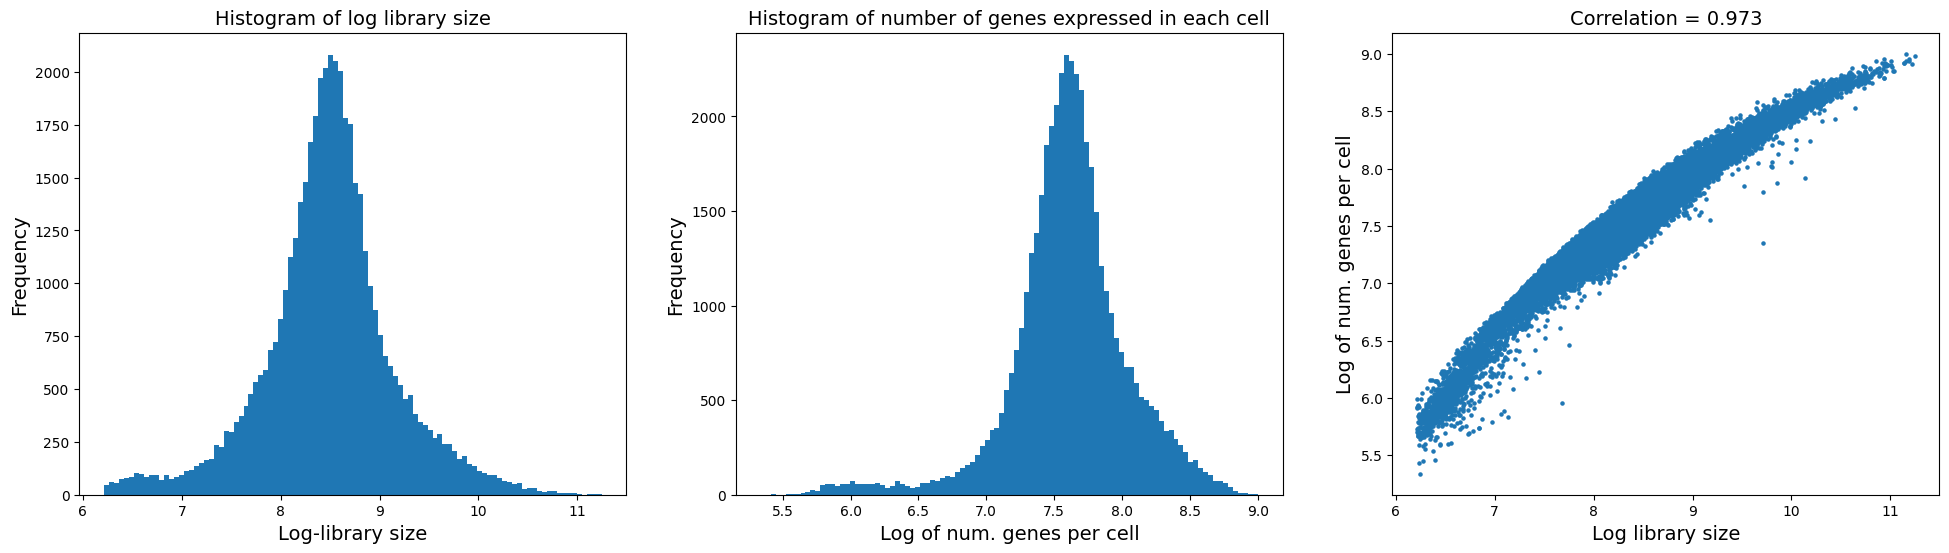

In [13]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(gex_all.obs['log1p_total_counts'], bins = 100);
ax.set_xlabel('Log-library size', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log library size', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(gex_all.obs['log1p_n_genes_by_counts'], bins = 100);
ax.set_xlabel('Log of num. genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of genes expressed in each cell', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
x = gex_all.obs['log1p_total_counts']
y = gex_all.obs['log1p_n_genes_by_counts']
ax.scatter(x, y, s = 5);
ax.set_ylabel('Log of num. genes per cell', fontsize = 14)
ax.set_xlabel('Log library size', fontsize = 14)
corr_coef = np.corrcoef(x, y)[0, 1]
ax.set_title('Correlation = ' + str(round(corr_coef, 3)), fontsize = 14)

(0.0, 1000.0)

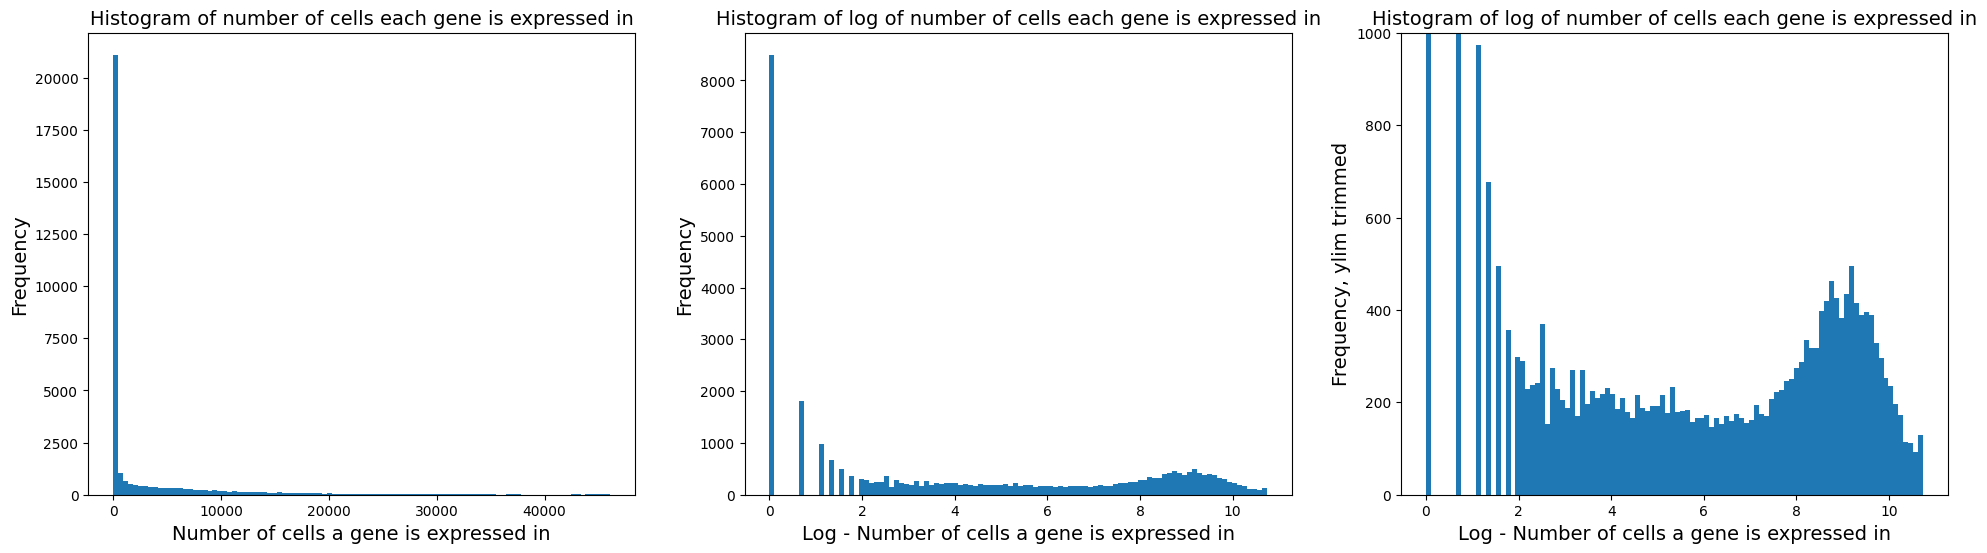

In [43]:
# number of genes each cell is expressed
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(gex_all.var['n_cells_by_counts'], bins = 100);
ax.set_xlabel('Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(np.log(gex_all.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.hist(np.log(gex_all.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency, ylim trimmed', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)
ax.set_ylim([0, 1000])

In [14]:
#Remove lowly expressed genes
sc.pp.filter_genes(gex_all, min_cells = np.exp(2))
gex_all

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 46095 × 18896
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [15]:
# Identify MT-genes
mito_genes = gex_all.var_names[gex_all.var_names.str.startswith('mt-')]

index_mito_genes = [gex_all.var_names.get_loc(j) for j in mito_genes]
mito_frac = np.asarray(np.sum(gex_all.X[:, index_mito_genes], axis = 1)/np.sum(gex_all.X, axis = 1)).squeeze() * 100
gex_all.obs['mito_frac'] = mito_frac

gex_all


AnnData object with n_obs × n_vars = 46095 × 18896
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

Text(0, 0.5, '% MT-content')

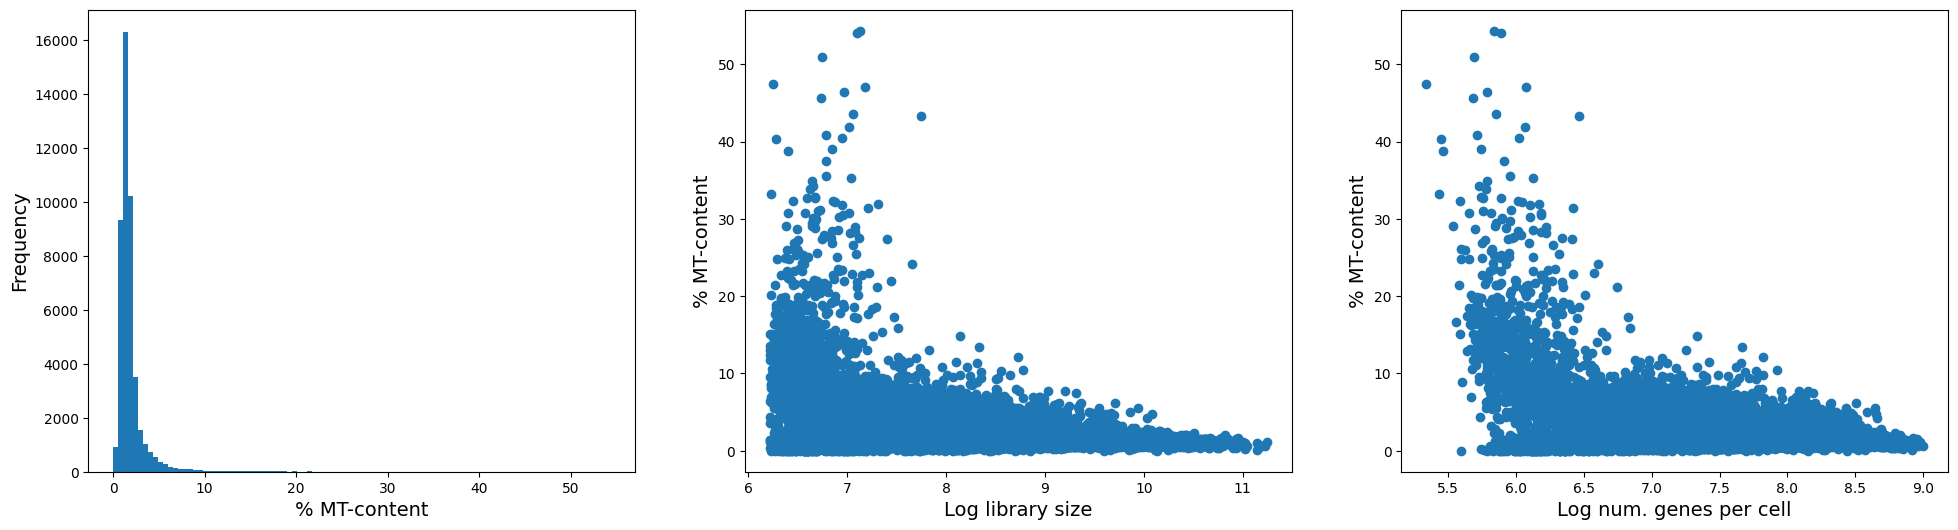

In [16]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(gex_all.obs['mito_frac'], 100);
ax.set_xlabel('% MT-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(gex_all.obs['log1p_total_counts'], gex_all.obs['mito_frac']);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(gex_all.obs['log1p_n_genes_by_counts'], gex_all.obs['mito_frac']);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

In [17]:
# Identify Ribo-genes
ribo_genes = gex_all.var_names[gex_all.var_names.str.startswith(('Rps', 'Rpl', 'Gm'))]
index_ribo_genes = [gex_all.var_names.get_loc(j) for j in ribo_genes]
ribo_frac = np.asarray(np.sum(gex_all.X[:, index_ribo_genes], axis = 1)/np.sum(gex_all.X, axis = 1)).squeeze() * 100
gex_all.obs['ribo_frac'] = ribo_frac

gex_all


AnnData object with n_obs × n_vars = 46095 × 18896
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

Text(0, 0.5, '% Ribo-content')

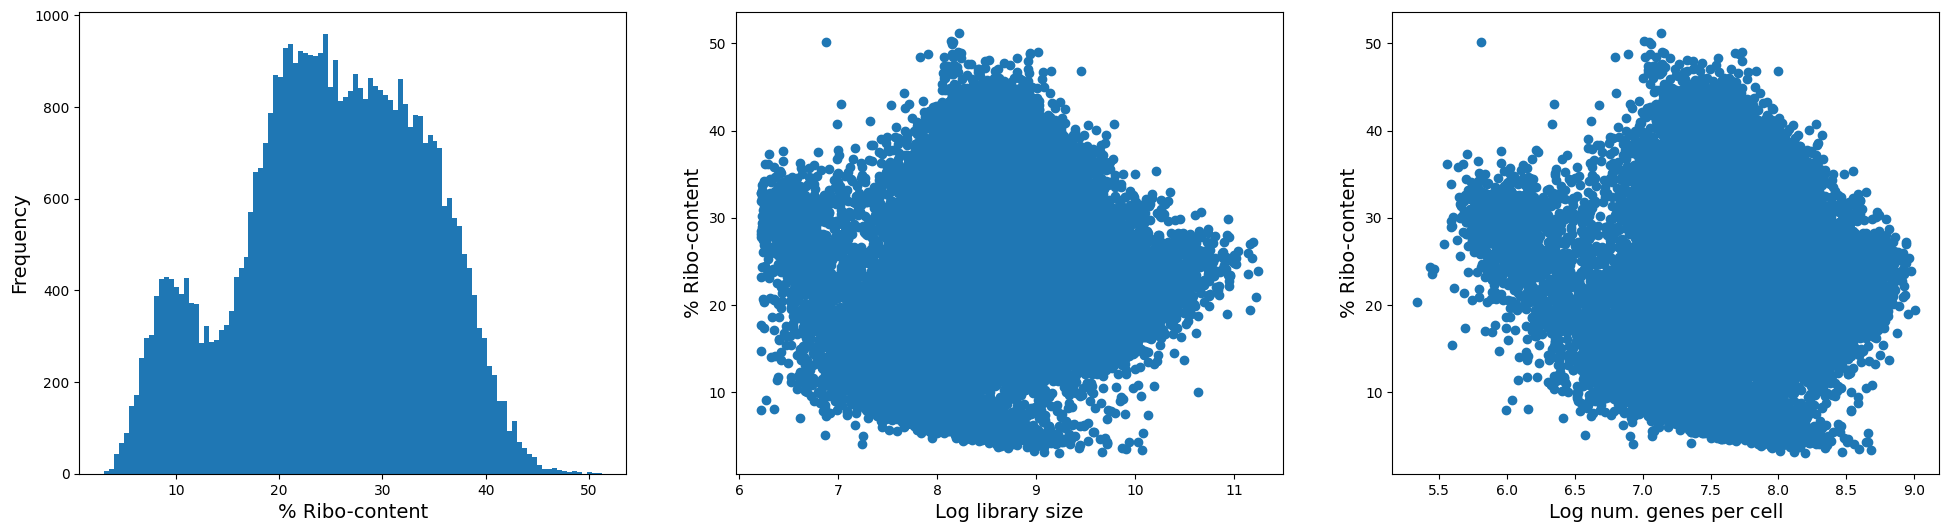

In [18]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(gex_all.obs['ribo_frac'], 100);
ax.set_xlabel('% Ribo-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1,3,2)
ax.scatter(gex_all.obs['log1p_total_counts'], gex_all.obs['ribo_frac']);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% Ribo-content', fontsize = 14)

ax = fig.add_subplot(1,3,3)
ax.scatter(gex_all.obs['log1p_n_genes_by_counts'], gex_all.obs['ribo_frac']);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% Ribo-content', fontsize = 14)

In [21]:
# remove ribo genes
ribo_mk = np.in1d(gex_all.var_names.values.astype(str), ribo_genes)
gex_all = gex_all[:,~ribo_mk]

In [22]:
gex_all

View of AnnData object with n_obs × n_vars = 46095 × 16096
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

##### Normalization

In [23]:
gex_all.layers['raw_data'] = gex_all.X.copy()
gex_all

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 46095 × 16096
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw_data'

In [24]:
sc.pp.normalize_total(gex_all, inplace = True)

gex_all.layers['norm_counts'] = gex_all.X.copy()

gex_all.X = np.log2(gex_all.X.toarray() + 1)

In [25]:
import scipy
gex_all.layers['zs_norm_log'] = scipy.stats.zscore(gex_all.X)


##### save

In [26]:
gex_all.write_h5ad('normalized_gex_all_no_ribo.h5ad')